In [1]:
from IPython import display
from lib import *
from ds_load import *
os.environ["CUDA_VISIBLE_DEVICES"]="0"

- Stage1. Dictionary 데이터 구조로 로드하기 (src,tgt)

In [127]:
src_idx_trn, src_idx_tst = (np.array([idx for idxes in [trn_0,trn_1,trn_2,trn_3,trn_4] for idx in idxes]),
                            np.array([idx for idxes in [tst_0,tst_1,tst_2,tst_3,tst_4] for idx in idxes]))

np.random.shuffle(src_idx_trn)
np.random.shuffle(src_idx_tst)

src_x_trn, src_y_trn = (x_train[src_idx_trn],y_train[src_idx_trn])
src_x_tst, src_y_tst = (x_test[src_idx_tst] ,y_test[src_idx_tst])

tgt_idx_trn, tgt_idx_tst = (np.array([idx for idxes in [trn_0,trn_3,trn_8,trn_9] for idx in idxes]),
                            np.array([idx for idxes in [tst_0,tst_3,tst_8,tst_9] for idx in idxes]))

np.random.shuffle(tgt_idx_trn)
np.random.shuffle(tgt_idx_tst)

tgt_x_trn, tgt_y_trn = (tx_train[tgt_idx_trn],ty_train[tgt_idx_trn])
tgt_x_tst, tgt_y_tst = (tx_test[tgt_idx_tst] ,ty_test[tgt_idx_tst])

dataset = {}

dataset['x_train'] = {'src':src_x_trn, 'tgt':tgt_x_trn}
dataset['y_train'] = {'src':src_y_trn, 'tgt':tgt_y_trn}

dataset['x_test'] = {'src':src_x_tst, 'tgt':tgt_x_tst}
dataset['y_test'] = {'src':src_y_tst, 'tgt':tgt_y_tst}

- Staget2. mini batch 데이터로 나누기

In [128]:
batch_sz = 64

def batch_dataloader(inp,lbl,batch_sz=batch_sz):
    
    batches_X,batches_Y = {},{}
    
    names = ['src','tgt']
    
    pvt_len = 1
    for name in names:
        if len(inp[name]) > pvt_len: 
            pvt_len = len(inp[name])
    
    epoch = pvt_len // batch_sz
    
    start = 0
    stop = start+batch_sz
    
    for idx in range(epoch):
        
        batch_X, batch_Y = {}, {}
        
        for name in names:
               
            sliced_inps= inp[name][start:stop]
            sliced_outs= lbl[name][start:stop]
            
            batch_X[name] = np.array(sliced_inps)
            batch_Y[name] = np.array(sliced_outs)
            
        batches_X[idx] = batch_X
        batches_Y[idx] = batch_Y
        
        start = stop
        stop += batch_sz
            
    return batches_X,batches_Y

train_inps, train_lbls = dataset['x_train'], dataset['y_train']
train_batch_inps, train_batch_lbls = batch_dataloader(train_inps, train_lbls)

- Stage3. 모델 아키텍쳐 설계 

In [129]:
latent_dim = 128

def Extractor():
    inp = Input(shape=(28,28,3), name="f_input")
    out = Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")(inp)
    out = MaxPooling2D(pool_size=(2, 2))(out)
    out = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(out)
    out = MaxPooling2D(pool_size=(2, 2))(out)
    out = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(out)
    out = MaxPooling2D(pool_size=(2, 2))(out)
    out = Flatten()(out)
    out = Dense(latent_dim, activation="relu",name='features')(out)
    return Model(inputs=inp, outputs=out, name="Extractor")

def Classifier():
    inp = Input(shape=(latent_dim,))
    out = Dense(1024, activation="relu")(inp)
    out = Dense(512, activation="relu")(out)
    out = Dense(64, activation="relu")(out)
    out = Dense(10, activation="softmax", name="cls_output")(out)
    return Model(inputs=inp, outputs=out,name="Classifier")

def build_model(extractor=Extractor(),classifier=Classifier()):
    inp = Input(shape=(28,28,3), name="input")
    feats = extractor(inp)
    out   = classifier(feats)
    model = Model(inputs=inp,outputs=out, name = "model")
    return model 

model = build_model()

- Stage4 Combine loss 설계 

In [130]:
# 훈련에 필요한 옵티마이저(optimizer)와 손실 함수를 선택합니다
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    # optimizer는 adam 
CrossEntropy = tf.keras.losses.categorical_crossentropy

# 모델의 손실과 성능을 측정할 지표를 선택합니다. 
# 에포크가 진행되는 동안 수집된 측정 지표를 바탕으로 최종 결과를 출력합니다.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

In [135]:
def DSNELoss(ft,y,trn,margin=1.0):
    names = ['src','tgt']

    names.remove(trn)
    cmp = names[0]

    dists = tf.abs((tf.expand_dims(ft[trn],axis=0) - tf.expand_dims(ft[cmp],axis=0))**2)
    dists = tf.reduce_mean(dists,axis=-1)[0]

    y_trn = y[trn].argmax(axis=1) 
    y_cmp = y[cmp].argmax(axis=1) 

    y_same = tf.math.equal(y_trn,y_cmp) # Boolean mask
    y_diff = tf.math.logical_not(y_same) # Boolean mask

    intraclass_dists = dists * y_same.numpy() # Set 0 where classes are different
    interclass_dists = dists * y_diff.numpy() # Set 0 where classes are the same

    # For each training image, find the minimum interclass distance
    interclass_dists_idx = tf.argmin(interclass_dists) # 다른 라벨 중 가장 가까운것을 
    min_interclass_dist = interclass_dists[interclass_dists_idx]

    # For each training image, find the maximum intraclass distance
    intraclass_dists_idx = tf.argmax(intraclass_dists) # 같은 라벨중 가장 큰 것을
    max_intraclass_dist = intraclass_dists[intraclass_dists_idx]

    differences = min_interclass_dist - max_intraclass_dist

    loss = tf.abs(differences-margin)
    #loss = tf.clip_by_value(loss,clip_value_min=0,clip_value_max=margin)

    return loss

In [147]:
def compute_loss(extractor, classifier, x, y, trn, alpha=0.1):
    feat = extractor(x[trn])
    y_hat = classifier(feat)
    lbl_loss = CrossEntropy(y[trn],y_hat)
    
    ft = {}
    for name in ['src','tgt']:
        ft[name]  = extractor(x[name])
        
    domain_loss = DSNELoss(ft, y, trn)
    total_loss = (1 - alpha)*tf.reduce_mean(lbl_loss) + (alpha*domain_loss.numpy())
        
    return total_loss

In [148]:
def train_step(models, ds, trn):
    extractor, classifier, model = models 
    x,y = ds 
    with tf.GradientTape() as tape:    

        total_loss = compute_loss(extractor, classifier, x, y, trn)

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    models = extractor, classifier, model
    return total_loss, models 

In [149]:
extractor = Extractor()
classifier = Classifier()
model = build_model(extractor,classifier)


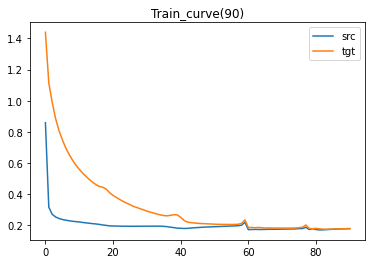

In [150]:
names = ['src','tgt']
num_steps = list(train_batch_inps.keys()) # 미니배치의 수 

history = {'src':[],'tgt':[]}

for epoch in range(100):
    
    losses = {'src':[],'tgt':[]}
    
    for batch_idx in num_steps:
        for trn in names:
            if train_batch_inps[batch_idx]['tgt'].shape == train_batch_inps[batch_idx]['src'].shape: 
                
                x,y = train_batch_inps[batch_idx], train_batch_lbls[batch_idx]
                total_loss, models = train_step(models=(extractor, classifier, model), ds=(x,y), trn=trn)
                extractor, classifier, model = models
                if total_loss.numpy()>0:
                    losses[trn].append(total_loss.numpy())
    
    history['src'].append(np.mean(losses['src']))
    history['tgt'].append(np.mean(losses['tgt']))

    if epoch % 10 == 0:
        plt.title(f'Train_curve({epoch})')
        plt.plot(history['src'],label='src')
        plt.legend()
        
        #plt.subplot(1,2,2)
        plt.plot(history['tgt'],label='tgt')
        plt.legend()
        
        plt.show()
        display.clear_output(wait=True)

In [137]:
# 모델 평가

In [136]:
for test_name,(x_gt, y_gt)in zip(['src_train','tgt_train']
                                ,[[src_x_trn, src_y_trn],[tgt_x_trn, tgt_y_trn]]):

    y_hat = model.predict(x_gt).argmax(axis=1)

    model.compile(loss=CrossEntropy,metrics='acc')
    test_loss, test_acc = model.evaluate(x_gt,y_gt)
    print('{} -->. {:.3f}'.format(test_name, test_acc*100),'%')


for test_name,(x_gt, y_gt)in zip(['src_test','tgt_test']
                                ,[[src_x_tst, src_y_tst],[tgt_x_tst, tgt_y_tst]]):

    y_hat = model.predict(x_gt).argmax(axis=1)

    model.compile(loss=CrossEntropy,metrics='acc')
    test_loss, test_acc = model.evaluate(x_gt,y_gt)
    print('{} -->. {:.3f}'.format(test_name, test_acc*100),'%')


161/161 [==============================] - 0s 2ms/step - loss: 0.0214 - acc: 0.9981
src_train -->. 99.805 %
124/124 [==============================] - 0s 2ms/step - loss: 0.0099 - acc: 0.9992
tgt_train -->. 99.924 %
17/17 [==============================] - 0s 2ms/step - loss: 0.0291 - acc: 0.9890
src_test -->. 98.897 %
12/12 [==============================] - 0s 2ms/step - loss: 0.7420 - acc: 0.8907
tgt_test -->. 89.067 %
